# Deep Learning for Building Exterior Cladding Classification Using Pre-trained CNNs

readme here

# → Setup (London)(After Augmentation)

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [51]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Details: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Details:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Plot visualization parameters

In [52]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Lucida Grande"]
# plt.rcParams['font.size'] = 12  
# plt.rcParams['axes.titlesize'] = 14   
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['xtick.labelsize'] = 10
# plt.rcParams['ytick.labelsize'] = 10

plt.style.use('fivethirtyeight')  

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Lucida Grande"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlepad": 15,
    "axes.labelpad": 10,
    "grid.color": "#e5e5e5"
})
mpl.rcParams['text.usetex'] = False


Paths

In [53]:
base_path_lon = '/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/london/after_augmentation'
train_path_lon = os.path.join(base_path_lon, 'train')
val_path_lon = os.path.join(base_path_lon, 'val')
test_path_lon = os.path.join(base_path_lon, 'test')

In [54]:
# parameters
BATCH_SIZE = 32
IMG_SIZE_RES   = (224, 224)
IMG_SIZE_INCEP = (299, 299)

In [55]:
# dataset prep ResNet50
train_ds_res = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
val_ds_res = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_ds_res = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_RES,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# dataset prep InceptionV3
train_ds_incep = tf.keras.utils.image_dataset_from_directory(
    train_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
val_ds_incep = tf.keras.utils.image_dataset_from_directory(
    val_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_ds_incep = tf.keras.utils.image_dataset_from_directory(
    test_path_lon,
    image_size=IMG_SIZE_INCEP,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds_res = train_ds_res.prefetch(AUTOTUNE)
val_ds_res   = val_ds_res.prefetch(AUTOTUNE)
test_ds_res  = test_ds_res.prefetch(AUTOTUNE)

train_ds_incep = train_ds_incep.prefetch(AUTOTUNE)
val_ds_incep   = val_ds_incep.prefetch(AUTOTUNE)
test_ds_incep  = test_ds_incep.prefetch(AUTOTUNE)


Found 6496 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Found 314 files belonging to 6 classes.
Found 6496 files belonging to 6 classes.
Found 308 files belonging to 6 classes.
Found 314 files belonging to 6 classes.


## Model (ResNet50)

In [56]:
# load ResNet50 base model
base_model_res = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model_res.trainable = False  # freeze base model

# build top classifier
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model_res(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_res = models.Model(inputs, outputs)

model_res.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
model_res.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### ResNet50 Training (London)

In [57]:
# optional: save the best model
checkpoint_cb_res = ModelCheckpoint("resnet_cladding_model.keras", save_best_only=True)

# optional: stop if validation accuracy doesn't improve for 3 epochs
earlystop_cb_res = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_res = None
model_path_res = 'resnet_cladding_model.keras'
if os.path.exists(model_path_res):
    model_res = load_model('resnet_cladding_model.keras')
    print("Loaded existing model -> resnet_cladding_model.keras")
else:
    print("No existing model found, starting training from scratch.")
    history_res = model_res.fit(
        train_ds_res,
        validation_data=val_ds_res,
        epochs=20,
        callbacks=[earlystop_cb_res, checkpoint_cb_res]
    )

No existing model found, starting training from scratch.
Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 270ms/step - accuracy: 0.4350 - loss: 2.7450 - val_accuracy: 0.6331 - val_loss: 1.6260
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.6184 - loss: 1.5255 - val_accuracy: 0.6266 - val_loss: 1.3371
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step - accuracy: 0.7179 - loss: 0.9903 - val_accuracy: 0.6916 - val_loss: 1.2016
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - accuracy: 0.7634 - loss: 0.7865 - val_accuracy: 0.6623 - val_loss: 1.1939
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 242ms/step - accuracy: 0.8025 - loss: 0.6925 - val_accuracy: 0.7045 - val_loss: 1.2326
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - accuracy: 0.8483 - loss: 0.5606 - val_accuracy: 0.7110 - val_loss: 1.2749
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 51s 251ms/step - accuracy: 0.8491 - loss: 0.5468 - val_accuracy: 0.6851 - val_loss: 1.3115


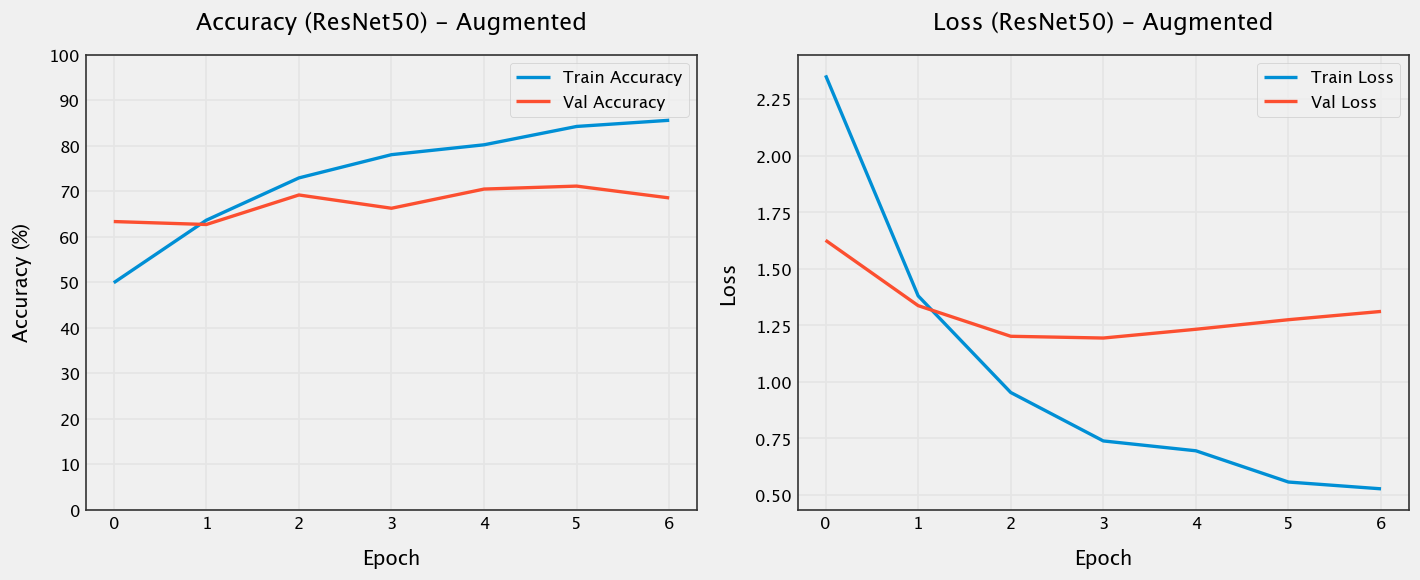

In [83]:
if history_res:
    acc = history_res.history['accuracy']
    val_acc = history_res.history['val_accuracy']
    loss = history_res.history['loss']
    val_loss = history_res.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy (ResNet50) - Augmented')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.yticks(range(0, 101, 10))
    plt.ylim([0, 100]) 

    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
    plt.title('Loss (ResNet50) - Augmented')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available, skipping accuracy/loss plot.")

### ResNet50 Test (London)

In [61]:
loss_res, acc_res = model_res.evaluate(test_ds_res)
print(f"Test accuracy: {acc_res:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6845 - loss: 1.0301
Test accuracy: 68.15%


              precision  recall  f1-score  support
Brick             94.37   75.28     83.75    89.00
Concrete          53.23   70.21     60.55    47.00
Curtain-Wall      80.00   26.67     40.00    15.00
Mixed             68.50   72.50     70.45   120.00
Others            44.19   55.88     49.35    34.00
Stone             66.67   44.44     53.33     9.00
accuracy          68.15   68.15     68.15     0.68
macro avg         67.82   57.50     59.57   314.00
weighted avg      71.41   68.15     68.51   314.00


2025-04-20 14:14:21.387097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


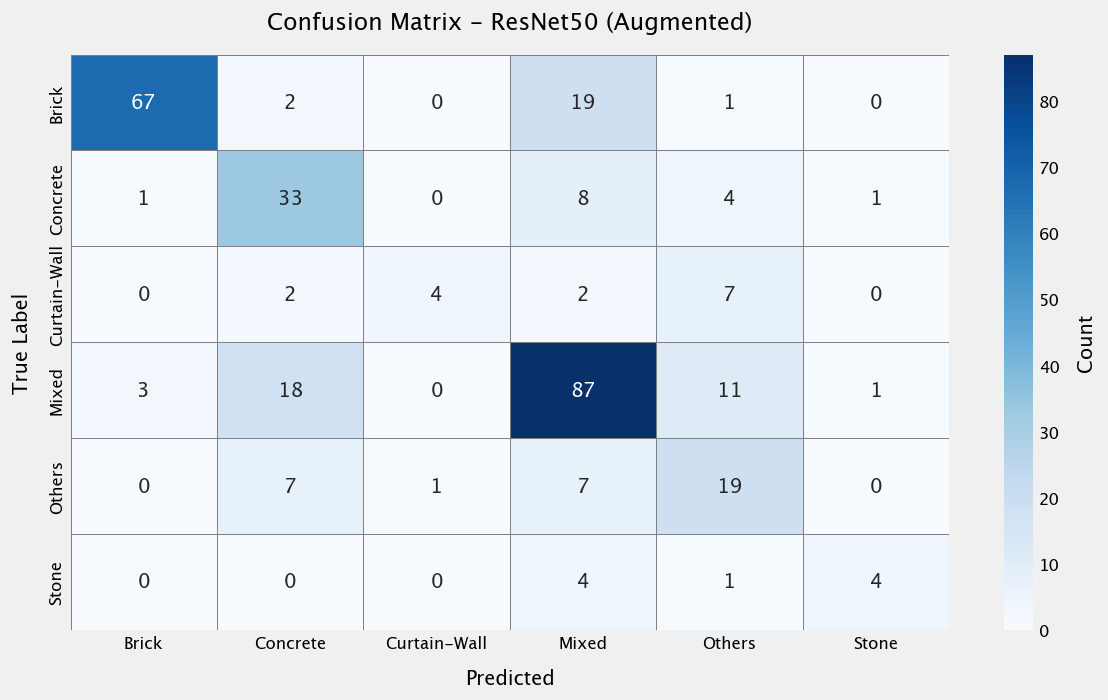

In [62]:
y_true = []
y_pred_probs = []

for x_batch, y_batch in test_ds_res:
    preds = model_res.predict(x_batch, verbose=0)
    y_pred_probs.append(preds)
    y_true.append(y_batch.numpy())

y_true = np.concatenate(y_true)
y_pred_probs = np.concatenate(y_pred_probs)
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).T
report_df[['precision', 'recall', 'f1-score']] *= 100
print(report_df[['precision', 'recall', 'f1-score', 'support']].round(2).to_string())

# confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
plt.title("Confusion Matrix - ResNet50 (Augmented)")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Model (Inception V3)

Build transfer learning model (Inception V3)

In [63]:
base_model_incep = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3),
)
base_model_incep.trainable = False  # freeze convolutional base

inputs_incep = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs_incep)
x = base_model_incep(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model_incep = Model(inputs_incep, outputs)

model_incep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_incep.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,830 (84.17 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Inception V3 Training (London)

In [64]:
checkpoint_cb_incep = ModelCheckpoint("inception_cladding_model.keras", save_best_only=True)

earlystop_cb_incep = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_incep = None
model_path_incep = 'inception_cladding_model.keras'
if os.path.exists(model_path_incep):
    model_incep = load_model('inception_cladding_model.keras')
    print("Loaded existing model -> inception_cladding_model.keras")
else:
    print("No existing model found, starting training from scratch.")
    history_incep = model_incep.fit(
        train_ds_incep,
        validation_data=val_ds_incep,
        epochs=35,
        callbacks=[earlystop_cb_incep, checkpoint_cb_incep]
    )

No existing model found, starting training from scratch.
Epoch 1/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 83s 364ms/step - accuracy: 0.3379 - loss: 3.6817 - val_accuracy: 0.6169 - val_loss: 1.1926
Epoch 2/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 60s 296ms/step - accuracy: 0.5171 - loss: 1.7605 - val_accuracy: 0.6591 - val_loss: 1.0040
Epoch 3/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 286ms/step - accuracy: 0.6049 - loss: 1.2176 - val_accuracy: 0.6591 - val_loss: 0.9987
Epoch 4/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 56s 277ms/step - accuracy: 0.6641 - loss: 0.9462 - val_accuracy: 0.6753 - val_loss: 0.9538
Epoch 5/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 285ms/step - accuracy: 0.6972 - loss: 0.8756 - val_accuracy: 0.6688 - val_loss: 0.9516
Epoch 6/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step - accuracy: 0.7439 - loss: 0.7457 - val_accuracy: 0.6429 - val_loss: 0.9907
Epoch 7/35
203/203 ━━━━━━━━━━━━━━━━━━━━ 58s 288ms/step - accuracy: 0.7295 - loss: 0.7802 - val_accuracy: 0.6656 - val_loss: 0.9564
Epoch 8/35
203/203 ━━━━━━━

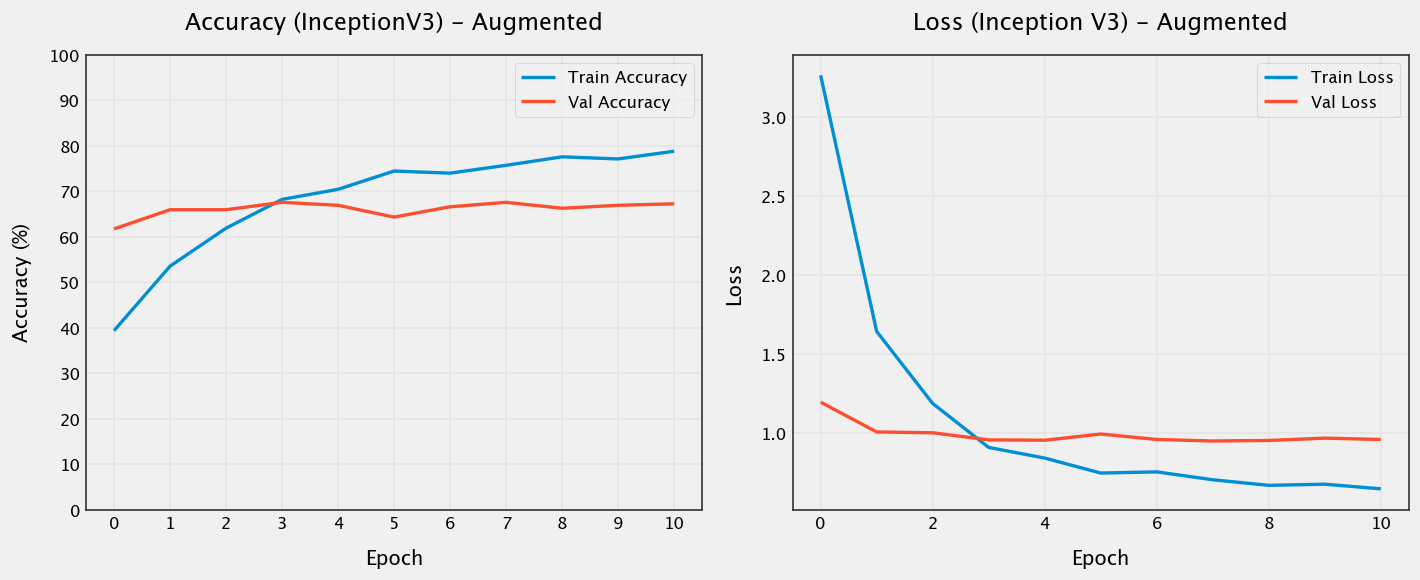

In [66]:
if history_incep:
    acc = history_incep.history['accuracy']
    val_acc = history_incep.history['val_accuracy']
    loss = history_incep.history['loss']
    val_loss = history_incep.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, [a * 100 for a in acc], label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, [va * 100 for va in val_acc], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy (InceptionV3) - Augmented')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.yticks(range(0, 101, 10))
    plt.ylim([0, 100]) 
    plt.xticks(epochs_range, [int(i) for i in epochs_range])  # Use integer ticks
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2)
    plt.title('Loss (Inception V3) - Augmented')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history available, skipping accuracy/loss plot.")

### Inception V3 Test (London)

In [67]:
loss_incep, acc_incep = model_incep.evaluate(test_ds_incep)
print(f"Test Accuracy: {acc_incep:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 821ms/step - accuracy: 0.6738 - loss: 0.9320
Test Accuracy: 70.38%


2025-04-20 17:21:27.716889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 740ms/step
              precision    recall  f1-score   support

       Brick       0.32      0.34      0.33        89
    Concrete       0.05      0.04      0.05        47
Curtain-Wall       0.00      0.00      0.00        15
       Mixed       0.37      0.42      0.40       120
      Others       0.16      0.12      0.14        34
       Stone       0.00      0.00      0.00         9

    accuracy                           0.28       314
   macro avg       0.15      0.15      0.15       314
weighted avg       0.26      0.28      0.27       314



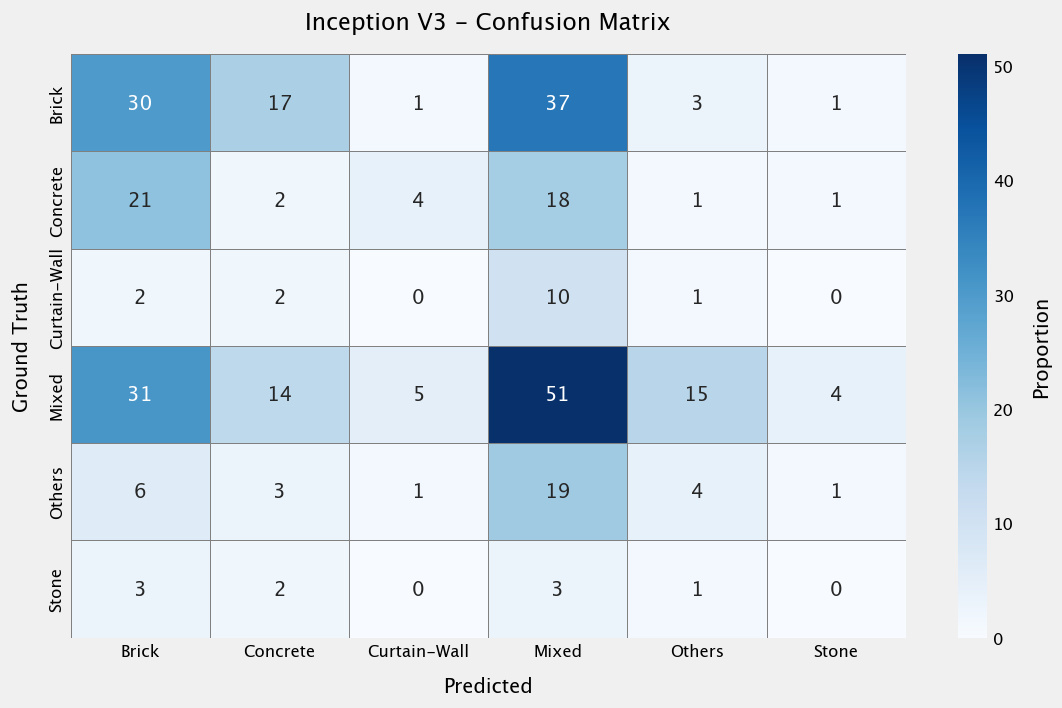

In [84]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_incep])
y_pred_probs = model_incep.predict(test_ds_incep)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print(classification_report(y_true_labels, y_pred, target_names=class_names))

cm = confusion_matrix(y_true_labels, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'})
plt.title("Inception V3 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

# → Setup for Scotland (For Generalizability Test)

In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [70]:
base_path_scot = '/Users/meltemsahin/Documents/GitHub/applied-deep-learning/data/exterior_cladding_material/scotland/before_augmentation'
test_path_scot = os.path.join(base_path_scot, 'test')

In [71]:
scot_test_res = tf.keras.utils.image_dataset_from_directory(
    test_path_scot,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

scot_test_incep = tf.keras.utils.image_dataset_from_directory(
    test_path_scot,
    image_size=(299, 299),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

Found 208 files belonging to 6 classes.
Found 208 files belonging to 6 classes.


2025-04-20 15:46:09.108054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


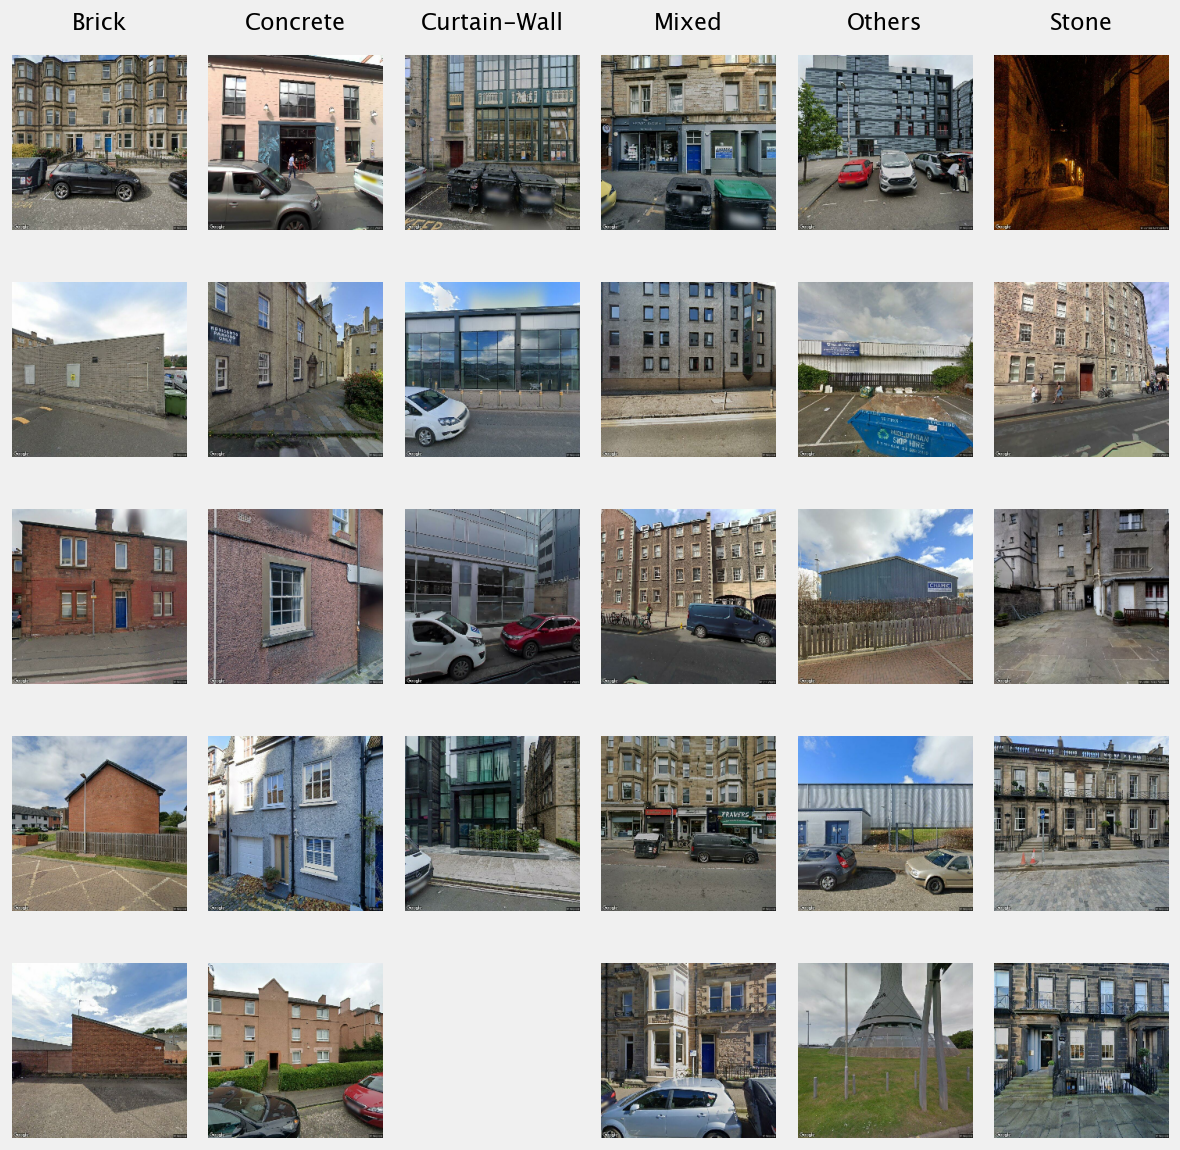

In [82]:
class_images = {class_name: [] for class_name in class_names}

for images, labels in scot_test_res.take(10):  # Take one batch of data
    for img, label in zip(images, labels):
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]
        if len(class_images[class_name]) < 5:  # Limit to 5 images per class
            class_images[class_name].append(img.numpy())

# visualize sample images of each class
plt.figure(figsize=(10, 10))
for class_idx, (class_name, imgs) in enumerate(class_images.items()):
    for img_idx, img in enumerate(imgs):
        ax = plt.subplot(5, len(class_names), img_idx * len(class_names) + class_idx + 1)
        plt.imshow(img.astype("uint8"))
        if img_idx == 0:
            plt.title(f"{class_name}", fontweight='bold')
        plt.axis("off")  
plt.tight_layout()
plt.show()

In [72]:
res_loss, res_acc = model_res.evaluate(scot_test_res)
print(f"ResNet50 (Augmented London → Scotland): Test Accuracy = {res_acc:.2%}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 952ms/step - accuracy: 0.4060 - loss: 2.5234
ResNet50 (Augmented London → Scotland): Test Accuracy = 32.21%


In [73]:
incep_loss, incep_acc = model_incep.evaluate(scot_test_incep)
print(f"InceptionV3 (Augmented London → Scotland): Test Accuracy = {incep_acc:.2%}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.4961 - loss: 1.9621
InceptionV3 (Augmented London → Scotland): Test Accuracy = 37.98%


📋 ResNet50 Report (Scotland Test Set):
              precision  recall  f1-score  support
Brick             15.25   56.25     24.00    16.00
Concrete          28.30   53.57     37.04    28.00
Curtain-Wall       0.00    0.00      0.00     4.00
Mixed             44.93   38.27     41.33    81.00
Others            37.50   45.00     40.91    20.00
Stone            100.00    5.08      9.68    59.00
accuracy          32.21   32.21     32.21     0.32
macro avg         37.66   33.03     25.49   208.00
weighted avg      54.45   32.21     29.61   208.00


2025-04-20 14:28:33.003851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/envs/applieddeeplearning_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/applieddeeplearning_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/applieddeeplearning_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision

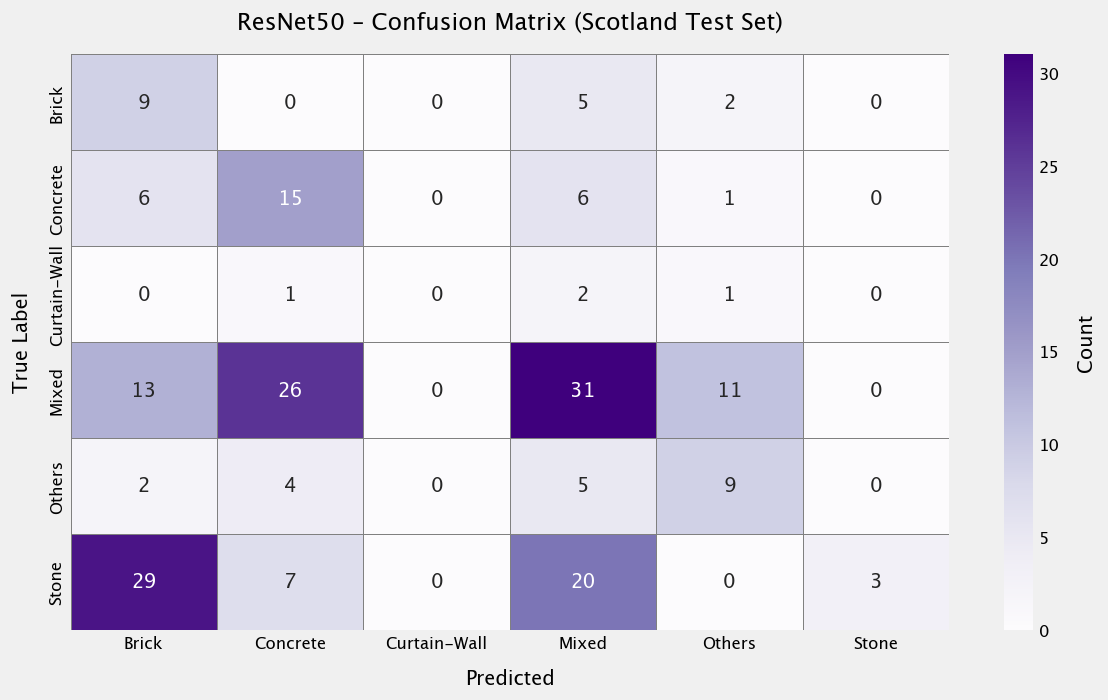

In [ ]:
# Predict on ResNet model with Scotland test data
y_true_res = []
y_pred_probs_res = []

for x_batch, y_batch in scot_test_res:
    preds = model_res.predict(x_batch, verbose=0)
    y_pred_probs_res.append(preds)
    y_true_res.append(y_batch.numpy())

y_true_res = np.concatenate(y_true_res)
y_pred_probs_res = np.concatenate(y_pred_probs_res)

y_true_labels_res = np.argmax(y_true_res, axis=1)
y_pred_labels_res = np.argmax(y_pred_probs_res, axis=1)

# Report
report_res = classification_report(y_true_labels_res, y_pred_labels_res, target_names=class_names, output_dict=True)
report_df_res = pd.DataFrame(report_res).T
report_df_res[['precision', 'recall', 'f1-score']] *= 100
print("ResNet50 Report (Scotland Test Set):")
print(report_df_res[['precision', 'recall', 'f1-score', 'support']].round(2))

# Confusion matrix
cm_res = confusion_matrix(y_true_labels_res, y_pred_labels_res)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_res, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Count'})
plt.title("ResNet50 – Confusion Matrix (Scotland Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


2025-04-20 14:28:47.698635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


📋 InceptionV3 Report (Scotland Test Set):
              precision  recall  f1-score  support
Brick             15.56   87.50     26.42    16.00
Concrete          40.00   42.86     41.38    28.00
Curtain-Wall       0.00    0.00      0.00     4.00
Mixed             62.86   54.32     58.28    81.00
Others            50.00   30.00     37.50    20.00
Stone             75.00    5.08      9.52    59.00
accuracy          37.98   37.98     37.98     0.38
macro avg         40.57   36.63     28.85   208.00
weighted avg      57.14   37.98     36.60   208.00


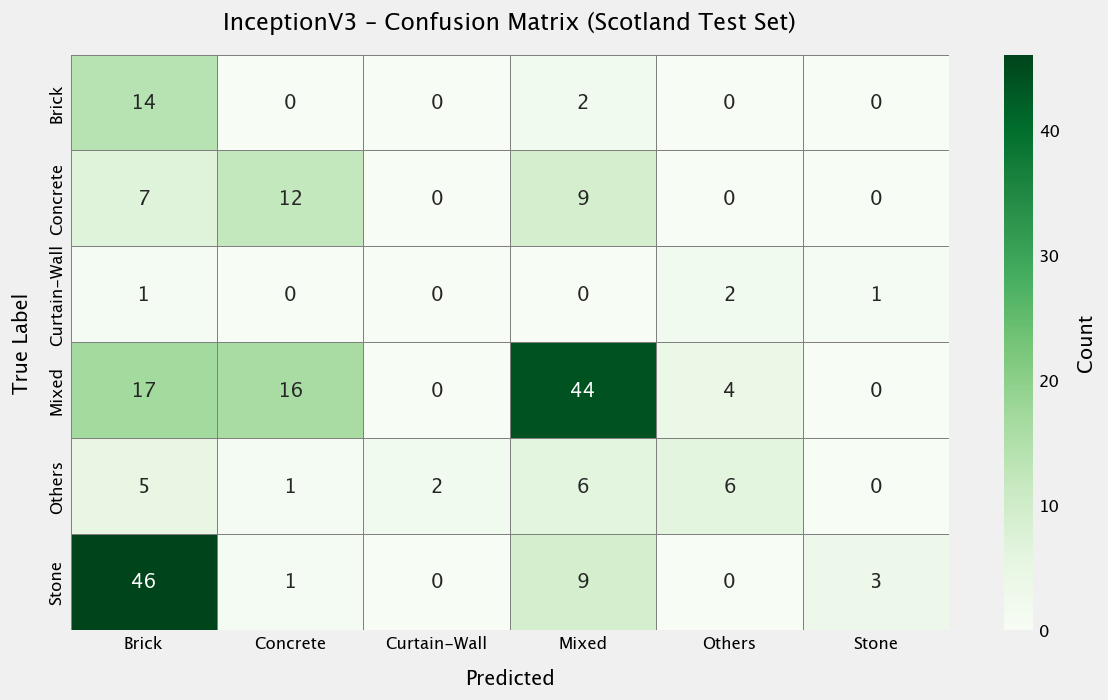

In [ ]:
# Predict on Inception model with Scotland test data
y_true_incep = []
y_pred_probs_incep = []

for x_batch, y_batch in scot_test_incep:
    preds = model_incep.predict(x_batch, verbose=0)
    y_pred_probs_incep.append(preds)
    y_true_incep.append(y_batch.numpy())

y_true_incep = np.concatenate(y_true_incep)
y_pred_probs_incep = np.concatenate(y_pred_probs_incep)

y_true_labels_incep = np.argmax(y_true_incep, axis=1)
y_pred_labels_incep = np.argmax(y_pred_probs_incep, axis=1)

# Report
report_incep = classification_report(y_true_labels_incep, y_pred_labels_incep, target_names=class_names, output_dict=True)
report_df_incep = pd.DataFrame(report_incep).T
report_df_incep[['precision', 'recall', 'f1-score']] *= 100
print("InceptionV3 Report (Scotland Test Set):")
print(report_df_incep[['precision', 'recall', 'f1-score', 'support']].round(2))

# Confusion matrix
cm_incep = confusion_matrix(y_true_labels_incep, y_pred_labels_incep)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_incep, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Count'})
plt.title("InceptionV3 – Confusion Matrix (Scotland Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
